In [84]:
import re
import pandas as pd
import numpy as np
from html import unescape
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import pos_tag, ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [83]:
# !pip install catboost optuna

In [37]:
df = pd.read_csv('elon_musk_tweets_labeled.csv')

In [38]:
df = df.drop(['id', 'hashtags', 'user_name', 'user_created', 'is_retweet', 'Unnamed: 0', 'date'], axis=1)

In [39]:
df.head()

,user_location,user_description,user_followers,user_friends,user_favourites,user_verified,text,source,retweets,favorites,feeling_auto
0,NaN,"Mars & Cars, Chips & Dips",101240855,115,13503,True,@BillyM2k I find the gold toe sock – inevitabl...,Twitter for iPhone,335,6542,0
1,NaN,"Mars & Cars, Chips & Dips",101240806,115,13503,True,"Sock Con, the conference for socks",Twitter for iPhone,1451,30753,1
2,NaN,"Mars & Cars, Chips & Dips",101240806,115,13503,True,Always something new for the magazine cover an...,Twitter for iPhone,1284,28610,1
3,NaN,"Mars & Cars, Chips & Dips",101240806,115,13503,True,@ExplainThisBob This guy gets it,Twitter for iPhone,131,3640,1
4,NaN,"Mars & Cars, Chips & Dips",101240806,115,13503,True,Sock tech is so advanced that you can get pret...,Twitter for iPhone,1191,23790,1


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5904 entries, 0 to 5903
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_location     1050 non-null   object
 1   user_description  1422 non-null   object
 2   user_followers    5904 non-null   int64 
 3   user_friends      5904 non-null   int64 
 4   user_favourites   5904 non-null   int64 
 5   user_verified     5904 non-null   bool  
 6   text              5904 non-null   object
 7   source            5904 non-null   object
 8   retweets          5904 non-null   int64 
 9   favorites         5904 non-null   int64 
 10  feeling_auto      5904 non-null   int64 
dtypes: bool(1), int64(6), object(4)
memory usage: 467.1+ KB


In [44]:
df = pd.get_dummies(df, columns=['user_location'], drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['user_description'], drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['user_verified'], drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['source'], drop_first=True, dtype=int)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5904 entries, 0 to 5903
Data columns (total 20 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   user_followers                                       5904 non-null   int64 
 1   user_friends                                         5904 non-null   int64 
 2   user_favourites                                      5904 non-null   int64 
 3   text                                                 5904 non-null   object
 4   retweets                                             5904 non-null   int64 
 5   favorites                                            5904 non-null   int64 
 6   feeling_auto                                         5904 non-null   int64 
 7   user_location_Boring                                 5904 non-null   int64 
 8   user_location_Hell                                   5904 non-null   int64 
 9

###Data preprocessing & cleaning

In [46]:
df['text'] = df['text'].apply(unescape)

In [47]:
HTML_symbols_check = ['&quot;', '&amp;', '&lt', '&gt;', '&apos;', '&#39;'] #Проверяем, что HTML-cущности заменены на соответствующие символы

for symbol in HTML_symbols_check:
    if df['text'].str.contains(symbol).any():
        print(f"Символ '{symbol}' найден в датасете.")
    else:
        print(f"Символ '{symbol}' не найден в датасете.")

Символ '&quot;' не найден в датасете.
Символ '&amp;' не найден в датасете.
Символ '&lt' не найден в датасете.
Символ '&gt;' не найден в датасете.
Символ '&apos;' не найден в датасете.
Символ '&#39;' не найден в датасете.


In [48]:
df['text'] = df['text'].str.replace(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', regex=True) #Удаляем emails
df['text'] = df['text'].str.replace(r'@([A-Za-z0-9_]{1,})', '', regex=True) #Удаляем ники
df['text'] = df['text'].str.replace(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', '', regex=True) #Удаляем urls

In [49]:
df['text'] = df['text'].str.lower()

In [50]:
df['text'] = df['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True) #Удаляем знаки препинания и цифры и оставляем только буквы и пробелы

In [51]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()  #Удаляем лишние пробелы

###Токенизация

In [52]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [53]:
df['tokens'] = df['text'].apply(word_tokenize)

In [54]:
df['tokens']

,tokens
0,"[i, find, the, gold, toe, sock, inevitably, of..."
1,"[sock, con, the, conference, for, socks]"
2,"[always, something, new, for, the, magazine, c..."
3,"[this, guy, gets, it]"
4,"[sock, tech, is, so, advanced, that, you, can,..."
...,...
5899,"[hes, not, wrong]"
5900,"[guys, i, think, i, maybe, took, too, much]"
5901,[cool]
5902,"[time, to, complete, the, circle]"


###Удаление стоп-слов

In [55]:
def delete_stopwords(tokens):
    cleaned = []
    for word in tokens:
        if word not in stop_words:
            cleaned.append(word)
    return cleaned

df['cleaned_tokens'] = df['tokens'].apply(delete_stopwords)

###Лемматизация

In [56]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [57]:
def lemmatize_tokens(tokens):
    lemmatized = []
    for word in tokens:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

df['lemmatized'] = df['cleaned_tokens'].apply(lemmatize_tokens)

In [58]:
df['lemmatized'] = df['lemmatized'].apply(' '.join)

In [59]:
df = df.drop(['text', 'tokens', 'cleaned_tokens'], axis=1)

###Bag-of-Words

In [60]:
df.head()

,user_followers,user_friends,user_favourites,retweets,favorites,feeling_auto,user_location_Boring,user_location_Hell,user_location_Trøllheim,user_location_Twitter HQ,user_location_Twitter NY,"user_description_Mars & Cars, Chips & Dips",user_description_Perfume Salesman,user_description_State-Affiliated Media,user_description_Twitter Complaint Hotline Operator,user_description_handsome/brilliant,user_description_nothing,user_verified_True,source_Twitter for iPhone,lemmatized
0,101240855,115,13503,335,6542,0,0,0,0,0,0,1,0,0,0,0,0,1,1,find gold toe sock inevitably kilter washed li...
1,101240806,115,13503,1451,30753,1,0,0,0,0,0,1,0,0,0,0,0,1,1,sock con conference sock
2,101240806,115,13503,1284,28610,1,0,0,0,0,0,1,0,0,0,0,0,1,1,always something new magazine cover article pr...
3,101240806,115,13503,131,3640,1,0,0,0,0,0,1,0,0,0,0,0,1,1,guy get
4,101240806,115,13503,1191,23790,1,0,0,0,0,0,1,0,0,0,0,0,1,1,sock tech advanced get pretty much anything so...


In [61]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['lemmatized'])

vocab = vectorizer.get_feature_names_out()
len(vocab)

6103

In [62]:
df.shape

(5904, 20)

In [63]:
bow_df = pd.DataFrame(X.toarray(), columns=vocab)

final_df_bow = pd.concat([df, bow_df], axis=1)
final_df_bow.head()

,user_followers,user_friends,user_favourites,retweets,favorites,feeling_auto,user_location_Boring,user_location_Hell,user_location_Trøllheim,user_location_Twitter HQ,...,zeal,zealand,zero,zerohedge,zip,zombie,zone,zoolander,zoom,zuck
0,101240855,115,13503,335,6542,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,101240806,115,13503,1451,30753,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,101240806,115,13503,1284,28610,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,101240806,115,13503,131,3640,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,101240806,115,13503,1191,23790,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###TF-IDF

In [64]:
tfidf_vectorizer = TfidfVectorizer()

X_tfidf = tfidf_vectorizer.fit_transform(df['lemmatized'])

feature_names = tfidf_vectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)
df_final_tfidf = pd.concat([df, df_tfidf], axis=1)

df_final_tfidf.head()

,user_followers,user_friends,user_favourites,retweets,favorites,feeling_auto,user_location_Boring,user_location_Hell,user_location_Trøllheim,user_location_Twitter HQ,...,zeal,zealand,zero,zerohedge,zip,zombie,zone,zoolander,zoom,zuck
0,101240855,115,13503,335,6542,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101240806,115,13503,1451,30753,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101240806,115,13503,1284,28610,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101240806,115,13503,131,3640,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,101240806,115,13503,1191,23790,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###ML part for BOW

In [112]:
X = final_df_bow.drop(['feeling_auto', 'lemmatized'], axis=1)
y = final_df_bow['feeling_auto']

In [113]:
X.shape

(5904, 6121)

In [114]:
scaler = MinMaxScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)

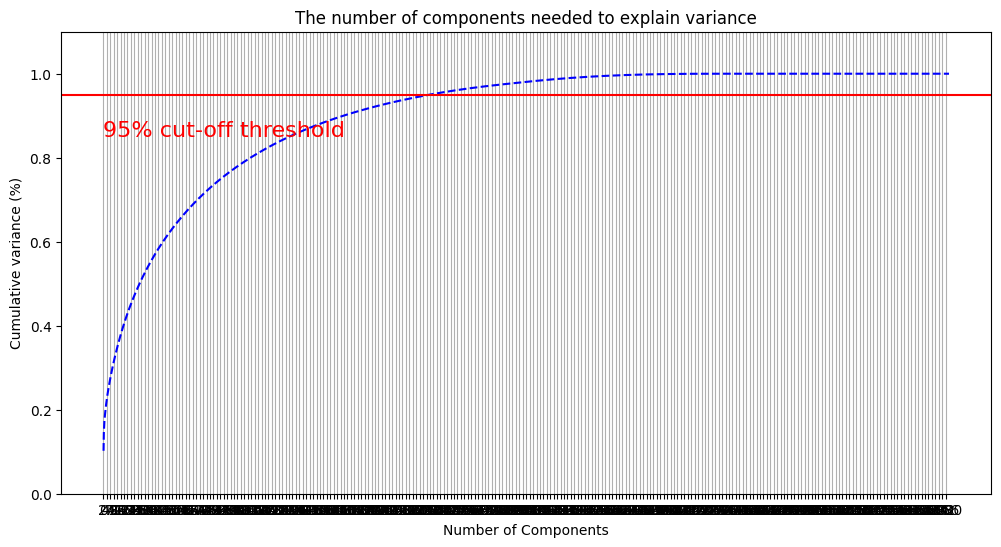

In [117]:
pca = PCA().fit(scaled_data)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 5905, step=1)
y_axe = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y_axe, linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5904, step=24))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [118]:
# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)
X_pca.shape

(5904, 2275)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [120]:
gnb_model = GaussianNB()
lr_model = LogisticRegression()
knn_model = KNeighborsClassifier()

In [121]:
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

gnb_model.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)

In [122]:
print(f'ROC-AUC LogisticRegression: {roc_auc_score(y_test, lr_pred)}')
print(f'ROC-AUC kNN: {roc_auc_score(y_test, knn_pred)}')
print(f'ROC-AUC GaussianNB: {roc_auc_score(y_test, gnb_pred)}')

ROC-AUC LogisticRegression: 0.714079647362821
ROC-AUC kNN: 0.5769889040887672
ROC-AUC GaussianNB: 0.6125885392916857


In [123]:
svc = SVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
lightgbm = LGBMClassifier()
catboost = CatBoostClassifier(silent=True)

In [124]:
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

xgboost.fit(X_train, y_train)
xgboost_pred = xgboost.predict(X_test)

lightgbm.fit(X_train, y_train)
lightgbm_pred = lightgbm.predict(X_test)

catboost.fit(X_train, y_train)
catboost_pred = catboost.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:38:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 2920, number of negative: 1803
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.335876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 580125
[LightGBM] [Info] Number of data points in the train set: 4723, number of used features: 2275
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618251 -> initscore=0.482132
[LightGBM] [Info] Start training from score 0.482132


In [125]:
print(f'ROC-AUC SupportVectorClassifier: {roc_auc_score(y_test, svc_pred)}')
print(f'ROC-AUC DecisionTreeClassifier: {roc_auc_score(y_test, dtc_pred)}')
print(f'ROC-AUC RandomForestClassifier: {roc_auc_score(y_test, rfc_pred)}')
print(f'ROC-AUC XGBoost: {roc_auc_score(y_test, xgboost_pred)}')
print(f'ROC-AUC LightGBM: {roc_auc_score(y_test, lightgbm_pred)}')
print(f'ROC-AUC CatBoost: {roc_auc_score(y_test, catboost_pred)}')

ROC-AUC SupportVectorClassifier: 0.6930551755585955
ROC-AUC DecisionTreeClassifier: 0.5858413132694938
ROC-AUC RandomForestClassifier: 0.6345812433500533
ROC-AUC XGBoost: 0.6465465876272989
ROC-AUC LightGBM: 0.6868931448548412
ROC-AUC CatBoost: 0.6677534579723362


In [126]:
# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [127]:
# import optuna

# def objective(trial):
#     params = {
#         "iterations": 500,
#         "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15, log=True),
#         "depth": trial.suggest_int("depth", 1, 5),
#         # "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 7),
#         # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#     }

#     model = CatBoostClassifier(**params, silent=True, random_seed=42)
#     model.fit(X_train_pca, y_train_pca)
#     predictions = model.predict(X_test_pca)
#     roc_auc_metric = roc_auc_score(y_test_pca, predictions)
#     return roc_auc_metric

In [128]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=5)

In [129]:
# print('Best hyperparameters:', study.best_params)
# print('Best roc_auc:', study.best_value)

In [130]:
# params = {
#     'iterations': [500],
#     'learning_rate': [0.01, 0.1],
#     'depth': [2, 4],
#     # 'l2_leaf_reg': [2, 3],
#     # 'loss_function': ['Logloss', 'CrossEntropy'],
#     # 'loss_function': ['Logloss'],
#     # 'logging_level': ['Silent'],
#     # 'random_seed': [42]
# }

In [131]:
# model = CatBoostClassifier()

In [132]:
# %%time
# grid_search = GridSearchCV(model, params, scoring='roc_auc', cv=3)

# grid_search.fit(X_train_pca, y_train_pca)


# print(grid_search.best_params_)


# auc_score = grid_search.score(X_test_pca, y_test_pca)
# print(f'AUC: {auc_score}')

###ML part for tf-IDF

In [133]:
X = df_final_tfidf.drop(['feeling_auto', 'lemmatized'], axis=1)
y = df_final_tfidf['feeling_auto']

In [134]:
X.shape

(5904, 6121)

In [135]:
scaler = MinMaxScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)

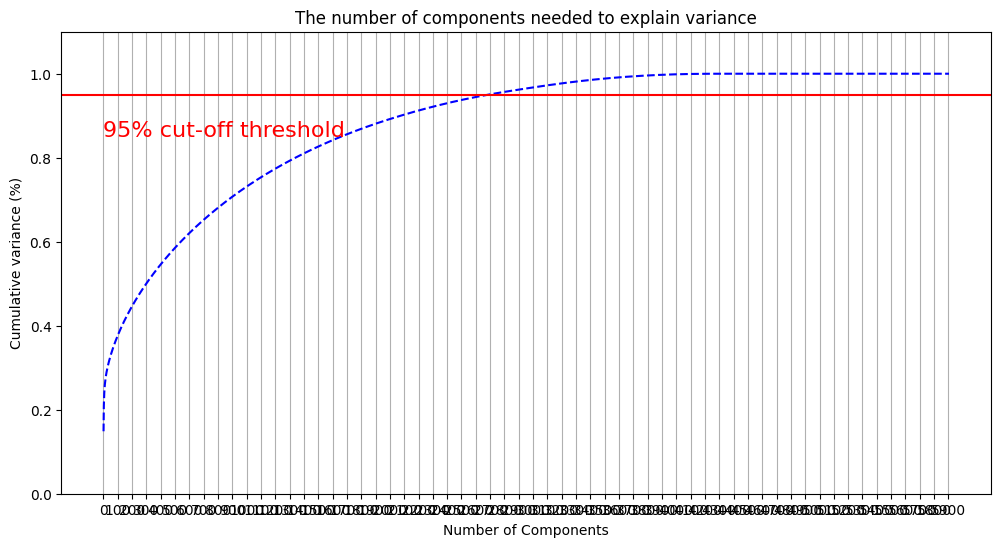

In [136]:
pca = PCA().fit(scaled_data)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 5905, step=1)
y_axe = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y_axe, linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5904, step=100))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [137]:
# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)
X_pca.shape

(5904, 2685)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [139]:
gnb_model = GaussianNB()
lr_model = LogisticRegression()
knn_model = KNeighborsClassifier()

In [140]:
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

gnb_model.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)

In [141]:
print(f'ROC-AUC LogisticRegression: {roc_auc_score(y_test, lr_pred)}')
print(f'ROC-AUC kNN: {roc_auc_score(y_test, knn_pred)}')
print(f'ROC-AUC GaussianNB: {roc_auc_score(y_test, gnb_pred)}')

ROC-AUC LogisticRegression: 0.6963018695850433
ROC-AUC kNN: 0.5422906216750265
ROC-AUC GaussianNB: 0.6013877488980088


In [142]:
svc = SVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
lightgbm = LGBMClassifier()
catboost = CatBoostClassifier(silent=True)

In [143]:
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

xgboost.fit(X_train, y_train)
xgboost_pred = xgboost.predict(X_test)

lightgbm.fit(X_train, y_train)
lightgbm_pred = lightgbm.predict(X_test)

catboost.fit(X_train, y_train)
catboost_pred = catboost.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:01:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 2920, number of negative: 1803
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684675
[LightGBM] [Info] Number of data points in the train set: 4723, number of used features: 2685
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618251 -> initscore=0.482132
[LightGBM] [Info] Start training from score 0.482132


In [144]:
print(f'ROC-AUC SupportVectorClassifier: {roc_auc_score(y_test, svc_pred)}')
print(f'ROC-AUC DecisionTreeClassifier: {roc_auc_score(y_test, dtc_pred)}')
print(f'ROC-AUC RandomForestClassifier: {roc_auc_score(y_test, rfc_pred)}')
print(f'ROC-AUC XGBoost: {roc_auc_score(y_test, xgboost_pred)}')
print(f'ROC-AUC LightGBM: {roc_auc_score(y_test, lightgbm_pred)}')
print(f'ROC-AUC CatBoost: {roc_auc_score(y_test, catboost_pred)}')

ROC-AUC SupportVectorClassifier: 0.6930551755585955
ROC-AUC DecisionTreeClassifier: 0.6099452804377565
ROC-AUC RandomForestClassifier: 0.6256923544611643
ROC-AUC XGBoost: 0.6534731722146223
ROC-AUC LightGBM: 0.6618483052135582
ROC-AUC CatBoost: 0.6774099407204742
